In [ ]:
#import os
import scanpy as sc
import anndata as ad
import pandas as pd
import cellxgene_census
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
import matplotlib.pyplot as plt
import umap.umap_ as umap
import leidenalg as la

In [3]:
metadata = pd.read_csv('/projects/bioinformatics/DB/scRNAseq_parkinson/metadata.csv')

obs_join_ids = list(metadata['observation_joinid'])
obs_value_filter = f'observation_joinid in {obs_join_ids}'

census = cellxgene_census.open_soma(census_version="2025-01-30")

cell_metadata = cellxgene_census.get_obs(
    census=census,
    organism="homo_sapiens",
    value_filter=obs_value_filter,
    column_names=["observation_joinid","cell_type"]
)


emb_names = ["scvi", "geneformer"]

census_version = "2025-01-30"


with cellxgene_census.open_soma(census_version=census_version) as census:
    adata = cellxgene_census.get_anndata(
        census,
        organism="homo_sapiens",
        measurement_name="RNA",
        obs_embeddings=emb_names,
        obs_value_filter=obs_value_filter,
        obs_column_names = ["observation_joinid",'cell_type']
    )


df_geneformer = pd.DataFrame(
    adata.obsm["geneformer"], 
    index=adata.obs_names
)
df_geneformer.to_csv("geneformer_embedding.csv")


df_geneformer = pd.read_csv("/projects/bioinformatics/DB/scRNAseq_parkinson/geneformer_embedding.csv", index_col=0)

# convert to AnnData
adata = ad.AnnData(df_geneformer.values)
adata.obs_names = df_geneformer.index
adata.var_names = df_geneformer.columns

# build graph
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X')

# Leiden clustering
sc.tl.leiden(adata, resolution=0.6)

# save clusters
adata.obs[['leiden']].to_csv("geneformer_leiden_clusters.csv")


read_leiden_clusters_geneformer = pd.read_csv('/home/znazari/scRNAseq_parkinson/geneformer_leiden_clusters.csv')

lm_data = metadata[['observation_joinid','disease','cell_type']]

df_merged_geneformer = pd.concat([lm_data,read_leiden_clusters_geneformer],axis=1)

df_merged_geneformer.drop('Unnamed: 0',axis=1,inplace=True)

# to make it joined celltype and the disease vs control geneformer

df_merged_geneformer["celltype_condition"] = (
    df_merged_geneformer["cell_type"].astype(str) + "_" + df_merged_geneformer["disease"].astype(str)
)

# Compute NMI between Leiden clusters and cell types
nmi_celltype = normalized_mutual_info_score(df_merged_geneformer['leiden'], df_merged_geneformer['cell_type'])
print("NMI Leiden vs Cell Type for geneformer:", nmi_celltype)

# Compute NMI between Leiden clusters and disease status
nmi_disease = normalized_mutual_info_score(df_merged_geneformer['leiden'], df_merged_geneformer['disease'])
print("NMI Leiden vs Disease for geneformer:", nmi_disease)

# for geneformer
nmi_combined = normalized_mutual_info_score(
    df_merged_geneformer['leiden'],
    df_merged_geneformer['celltype_condition']
)

print("NMI Leiden vs CellType_Condition:", nmi_combined)

In [1]:
import scanpy as sc
import anndata as ad
import pandas as pd
from sklearn.metrics import normalized_mutual_info_score

In [4]:
# Load embedding
df_geneformer = pd.read_csv(
    "/projects/bioinformatics/DB/scRNAseq_parkinson/geneformer_embedding.csv",
    index_col=0
)

In [5]:
# Load metadata properly
metadata = pd.read_csv('/projects/bioinformatics/DB/scRNAseq_parkinson/metadata.csv')

In [6]:
# Step 1: create AnnData
adata = ad.AnnData(df_geneformer.values)

# Step 2: optionally give obs_names
adata.obs_names = df_geneformer.index.astype(str)  # or just leave them as 0,1,2...

# Step 3: assign metadata by position
adata.obs["disease"] = metadata["disease"].values
adata.obs["cell_type"] = metadata["cell_type"].values

# Step 4: combined label
adata.obs["celltype_condition"] = (
    adata.obs["cell_type"].astype(str) + "_" + adata.obs["disease"].astype(str)
)

# Step 5: check
#adata.obs.head()
adata.obs.isna().mean()


disease               0.0
cell_type             0.0
celltype_condition    0.0
dtype: float64

In [8]:
adata.obs

,disease,cell_type,celltype_condition
0,Parkinson disease,oligodendrocyte,oligodendrocyte_Parkinson disease
1,Parkinson disease,oligodendrocyte,oligodendrocyte_Parkinson disease
2,Parkinson disease,oligodendrocyte,oligodendrocyte_Parkinson disease
3,Parkinson disease,oligodendrocyte,oligodendrocyte_Parkinson disease
4,Parkinson disease,astrocyte,astrocyte_Parkinson disease
...,...,...,...
2096150,normal,oligodendrocyte,oligodendrocyte_normal
2096151,Parkinson disease,glutamatergic neuron,glutamatergic neuron_Parkinson disease
2096152,Parkinson disease,central nervous system macrophage,central nervous system macrophage_Parkinson di...
2096153,normal,oligodendrocyte precursor cell,oligodendrocyte precursor cell_normal


In [9]:
# Build graph once
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X')
adata.write("adata_geneformer_with_neighbors.h5ad")

In [10]:
adata = sc.read('adata_geneformer_with_neighbors.h5ad')

In [11]:
# Smart function to compute NMI
def compute_nmi_table(adata, resolutions, label_keys):
    results = []

    for res in resolutions:
        key = f"leiden_r{res}"
        sc.tl.leiden(adata, resolution=res, key_added=key, random_state=0)

        for label in label_keys:
            valid = adata.obs[[key, label]].dropna()

            nmi = normalized_mutual_info_score(
                valid[key].astype(str),
                valid[label].astype(str)
            )

            results.append({
                "resolution": res,
                "label": label,
                "NMI": nmi
            })

    return pd.DataFrame(results)


In [12]:
# Run
resolutions = [0.3, 0.5, 0.8, 1.0]

labels_to_test = [
    "cell_type",
    "disease",
    "celltype_condition"
]

nmi_results = compute_nmi_table(
    adata,
    resolutions=resolutions,
    label_keys=labels_to_test
)

print(nmi_results)


/var/tmp/pbs.406741.pbs01/ipykernel_2228/4272938209.py:7: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=res, key_added=key, random_state=0)


    resolution               label       NMI
0          0.3           cell_type  0.836871
1          0.3             disease  0.000926
2          0.3  celltype_condition  0.728331
3          0.5           cell_type  0.827171
4          0.5             disease  0.000912
5          0.5  celltype_condition  0.721297
6          0.8           cell_type  0.740433
7          0.8             disease  0.002097
8          0.8  celltype_condition  0.655570
9          1.0           cell_type  0.705669
10         1.0             disease  0.002184
11         1.0  celltype_condition  0.628347


In [13]:
# Save everything
nmi_results.to_csv("geneformer_nmi_by_resolution.csv", index=False)
adata.write("adata_geneformer_leiden_sweep.h5ad")


In [9]:
nmi_result = pd.read_csv("geneformer_nmi_by_resolution.csv")

In [8]:
nmi_result

,resolution,label,NMI
0,0.3,cell_type,0.836871
1,0.3,disease,0.000926
2,0.3,celltype_condition,0.728331
3,0.5,cell_type,0.827171
4,0.5,disease,0.000912
5,0.5,celltype_condition,0.721297
6,0.8,cell_type,0.740433
7,0.8,disease,0.002097
8,0.8,celltype_condition,0.655570
9,1.0,cell_type,0.705669


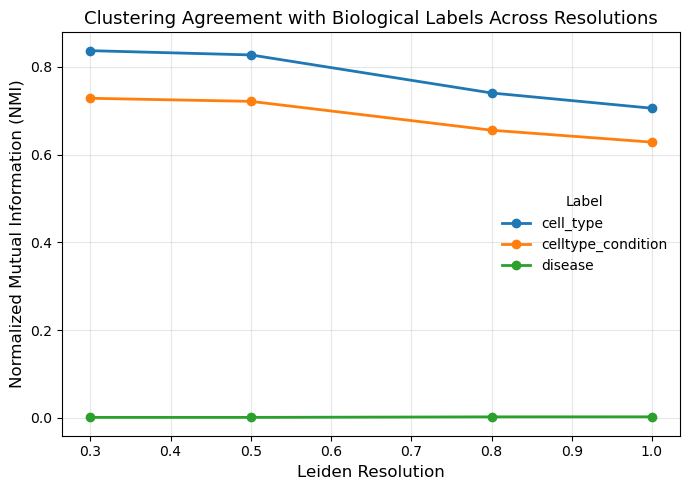

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Pivot for clean plotting
pivot_df = nmi_result.pivot(index="resolution", columns="label", values="NMI")

# Create figure
plt.figure(figsize=(7, 5))

# Plot each label (no explicit colors)
for col in pivot_df.columns:
    plt.plot(
        pivot_df.index,
        pivot_df[col],
        marker="o",
        linewidth=2,
        label=col
    )

# Axis labels
plt.xlabel("Leiden Resolution", fontsize=12)
plt.ylabel("Normalized Mutual Information (NMI)", fontsize=12)

# Title
plt.title("Clustering Agreement with Biological Labels Across Resolutions", fontsize=13)

# Legend
plt.legend(frameon=False, title="Label")

# Grid (subtle, journal style)
plt.grid(alpha=0.3)

# Layout
plt.tight_layout()

plt.show()
